# This project consists of mainly two components: Computer Vision, Neural Network model

In [33]:
# Constants and Functions
import re
import os
import sys
import cv2
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import pytesseract

from imutils.object_detection import non_max_suppression
from speedml import Speedml
from sklearn.preprocessing import MinMaxScaler

TESSERACT_PATH = 'C:\Program Files\Tesseract-OCR\tesseract.exe'
IMG_PATH_1 = 'data/PHX@MIL.jpg'
EAST_PATH = 'models/frozen_east_text_detection.pb'
pytesseract.pytesseract.tesseract_cmd = 'C:\\Program Files\\Tesseract-OCR\\tesseract.exe'

REF_START_X_1 = 231
REF_END_X_1 = 367
REF_START_Y_1 = 1236
REF_END_Y_1 = 1314
REF_START_X_2 = 855
REF_END_X_2 = 1007
REF_START_Y_2 = 1236
REF_END_Y_2 = 1318

all_alpha = re.compile('[^a-zA-Z]')

# Function for implementation of OpenCV's EAST
def east_detect(image):
    layerNames = [
        "feature_fusion/Conv_7/Sigmoid",
        "feature_fusion/concat_3"]

    orig = image.copy()

    if len(image.shape) == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    (H, W) = image.shape[:2]

    # set the new width and height and then determine the ratio in change
    # for both the width and height: Should be multiple of 32
    (newW, newH) = (320, 320)

    rW = W / float(newW)
    rH = H / float(newH)

    # resize the image and grab the new image dimensions
    image = cv2.resize(image, (newW, newH))

    (H, W) = image.shape[:2]

    net = cv2.dnn.readNet(EAST_PATH)

    blob = cv2.dnn.blobFromImage(image, 1.0, (W, H),
        (123.68, 116.78, 103.94), swapRB=True, crop=False)

    start = time.time()

    net.setInput(blob)

    (scores, geometry) = net.forward(layerNames)

    (numRows, numCols) = scores.shape[2:4]
    rects = []
    confidences = []
    # loop over the number of rows
    for y in range(0, numRows):
        # extract the scores (probabilities), followed by the geometrical
        # data used to derive potential bounding box coordinates that
        # surround text
        scoresData = scores[0, 0, y]
        xData0 = geometry[0, 0, y]
        xData1 = geometry[0, 1, y]
        xData2 = geometry[0, 2, y]
        xData3 = geometry[0, 3, y]
        anglesData = geometry[0, 4, y]

        for x in range(0, numCols):
            # if our score does not have sufficient probability, ignore it
            # Set minimum confidence as required
            if scoresData[x] < 0.5:
                continue
            # compute the offset factor as our resulting feature maps will
            #  x smaller than the input image
            (offsetX, offsetY) = (x * 4.0, y * 4.0)
            # extract the rotation angle for the prediction and then
            # compute the sin and cosine
            angle = anglesData[x]
            cos = np.cos(angle)
            sin = np.sin(angle)
            # use the geometry volume to derive the width and height of
            # the bounding box
            h = xData0[x] + xData2[x]
            w = xData1[x] + xData3[x]
            # compute both the starting and ending (x, y)-coordinates for
            # the text prediction bounding box
            endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
            endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
            startX = int(endX - w)
            startY = int(endY - h)
            # add the bounding box coordinates and probability score to
            # our respective lists
            rects.append((startX, startY, endX, endY))
            confidences.append(scoresData[x])

    boxes = non_max_suppression(np.array(rects), probs=confidences)
    rectangles = []
    # loop over the bounding boxes
    for (startX, startY, endX, endY) in boxes:
        # scale the bounding box coordinates based on the respective
        # ratios
        startX = int(startX * rW)
        startY = int(startY * rH)
        endX = int(endX * rW)
        endY = int(endY * rH)
        # draw the bounding box on the image
        cv2.rectangle(orig, (startX, startY), (endX, endY), (0, 255, 0), 2)
        rectangles.append({
            'startX': startX,
            'endX': endX,
            'startY': startY,
            'endY': endY
        })


    print(time.time() - start)
    return orig, rectangles

# Function for converting an image to a NBA's team name abbreviation
def get_abbv(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret, bw_img = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)

    abbv = pytesseract.image_to_string(bw_img, lang='eng', config='--psm 7')
    
    return all_alpha.sub('', abbv)

# Function to find the most probable team name rectangle in the image generated from EAST
def find_best_rectangles(rectangles):
    diffXRec1 = diffYRec1 = diffXRec2 = diffYRec2 = 9999
    
    for coordDict in rectangles:
        if abs(REF_START_X_1 - coordDict['startX'])+abs(REF_END_X_1 - coordDict['endX']) < diffXRec1 and\
        abs(REF_START_Y_1 - coordDict['startY'])+abs(REF_END_Y_1 - coordDict['endY']) < diffYRec1:
            bestRec1 = coordDict
            diffXRec1 = abs(REF_START_X_1 - coordDict['startX'])+abs(REF_END_X_1 - coordDict['endX'])
            diffYRec1 = abs(REF_START_Y_1 - coordDict['startY'])+abs(REF_END_Y_1 - coordDict['endY'])

        if abs(REF_START_X_2 - coordDict['startX'])+abs(REF_END_X_2 - coordDict['endX']) < diffXRec2 and\
        abs(REF_START_Y_2 - coordDict['startY'])+abs(REF_END_Y_2 - coordDict['endY']) < diffYRec2:
            bestRec2 = coordDict
            diffXRec2 = abs(REF_START_X_2 - coordDict['startX'])+abs(REF_END_X_2 - coordDict['endX'])
            diffYRec2 = abs(REF_START_Y_2 - coordDict['startY'])+abs(REF_END_Y_2 - coordDict['endY'])
            
    return bestRec1, bestRec2

# Function for One-hot encoding
def one_hot(df, col):
    one_hot_col = pd.get_dummies(df[col])
    df = df.drop(col, axis = 1)
    df = df.join(one_hot_col)
    return df 

# Function for cleaning the dataframe (not necessary but cleaner)
def clean_df(df):
    df['PTS_HOME'] = df['PTS_home']
    df = df.drop('PTS_home', axis = 1)
    
    df['FG_PCT_HOME'] = df['FG_PCT_home']
    df = df.drop('FG_PCT_home', axis = 1)
    
    df['HOME_TEAM_WON'] = df['HOME_TEAM_WINS']
    df = df.drop('HOME_TEAM_WINS', axis = 1)
    
    return df

# Function to create neural network
# 23 nodes in the hidden layer due to features*(2/3)+1 from output layer
def create_model():
    nn = tf.keras.models.Sequential()
    nn.add(tf.keras.layers.Dense(units=23, activation='relu'))
    nn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
    nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return nn

# Function to get predictions and append to testDF
def get_predictions(testDF, X_test):
    prediction_test = nn.predict(X_test)
    testDF['prediction'] = prediction_test
    testDF['binary_prediction'] = np.where(testDF['prediction']<0.5, 0, 1)
    return testDF

# Function to get accuracy
def get_accuracy(testDF):
    score = 0
    for index, row in testDF.iterrows():
        if row['HOME_TEAM_WON'] == row['binary_prediction']:
            score += 1
    accuracy = score/testDF.shape[0]
    return accuracy

# COMPUTER VISION

In [2]:
# Read image and save boxes with texts
image = cv2.imread(IMG_PATH_1)
out_image, rectangles = east_detect(image)
cv2.imwrite("data/text_rectangles_in_image.jpg", out_image)

0.16715216636657715


True

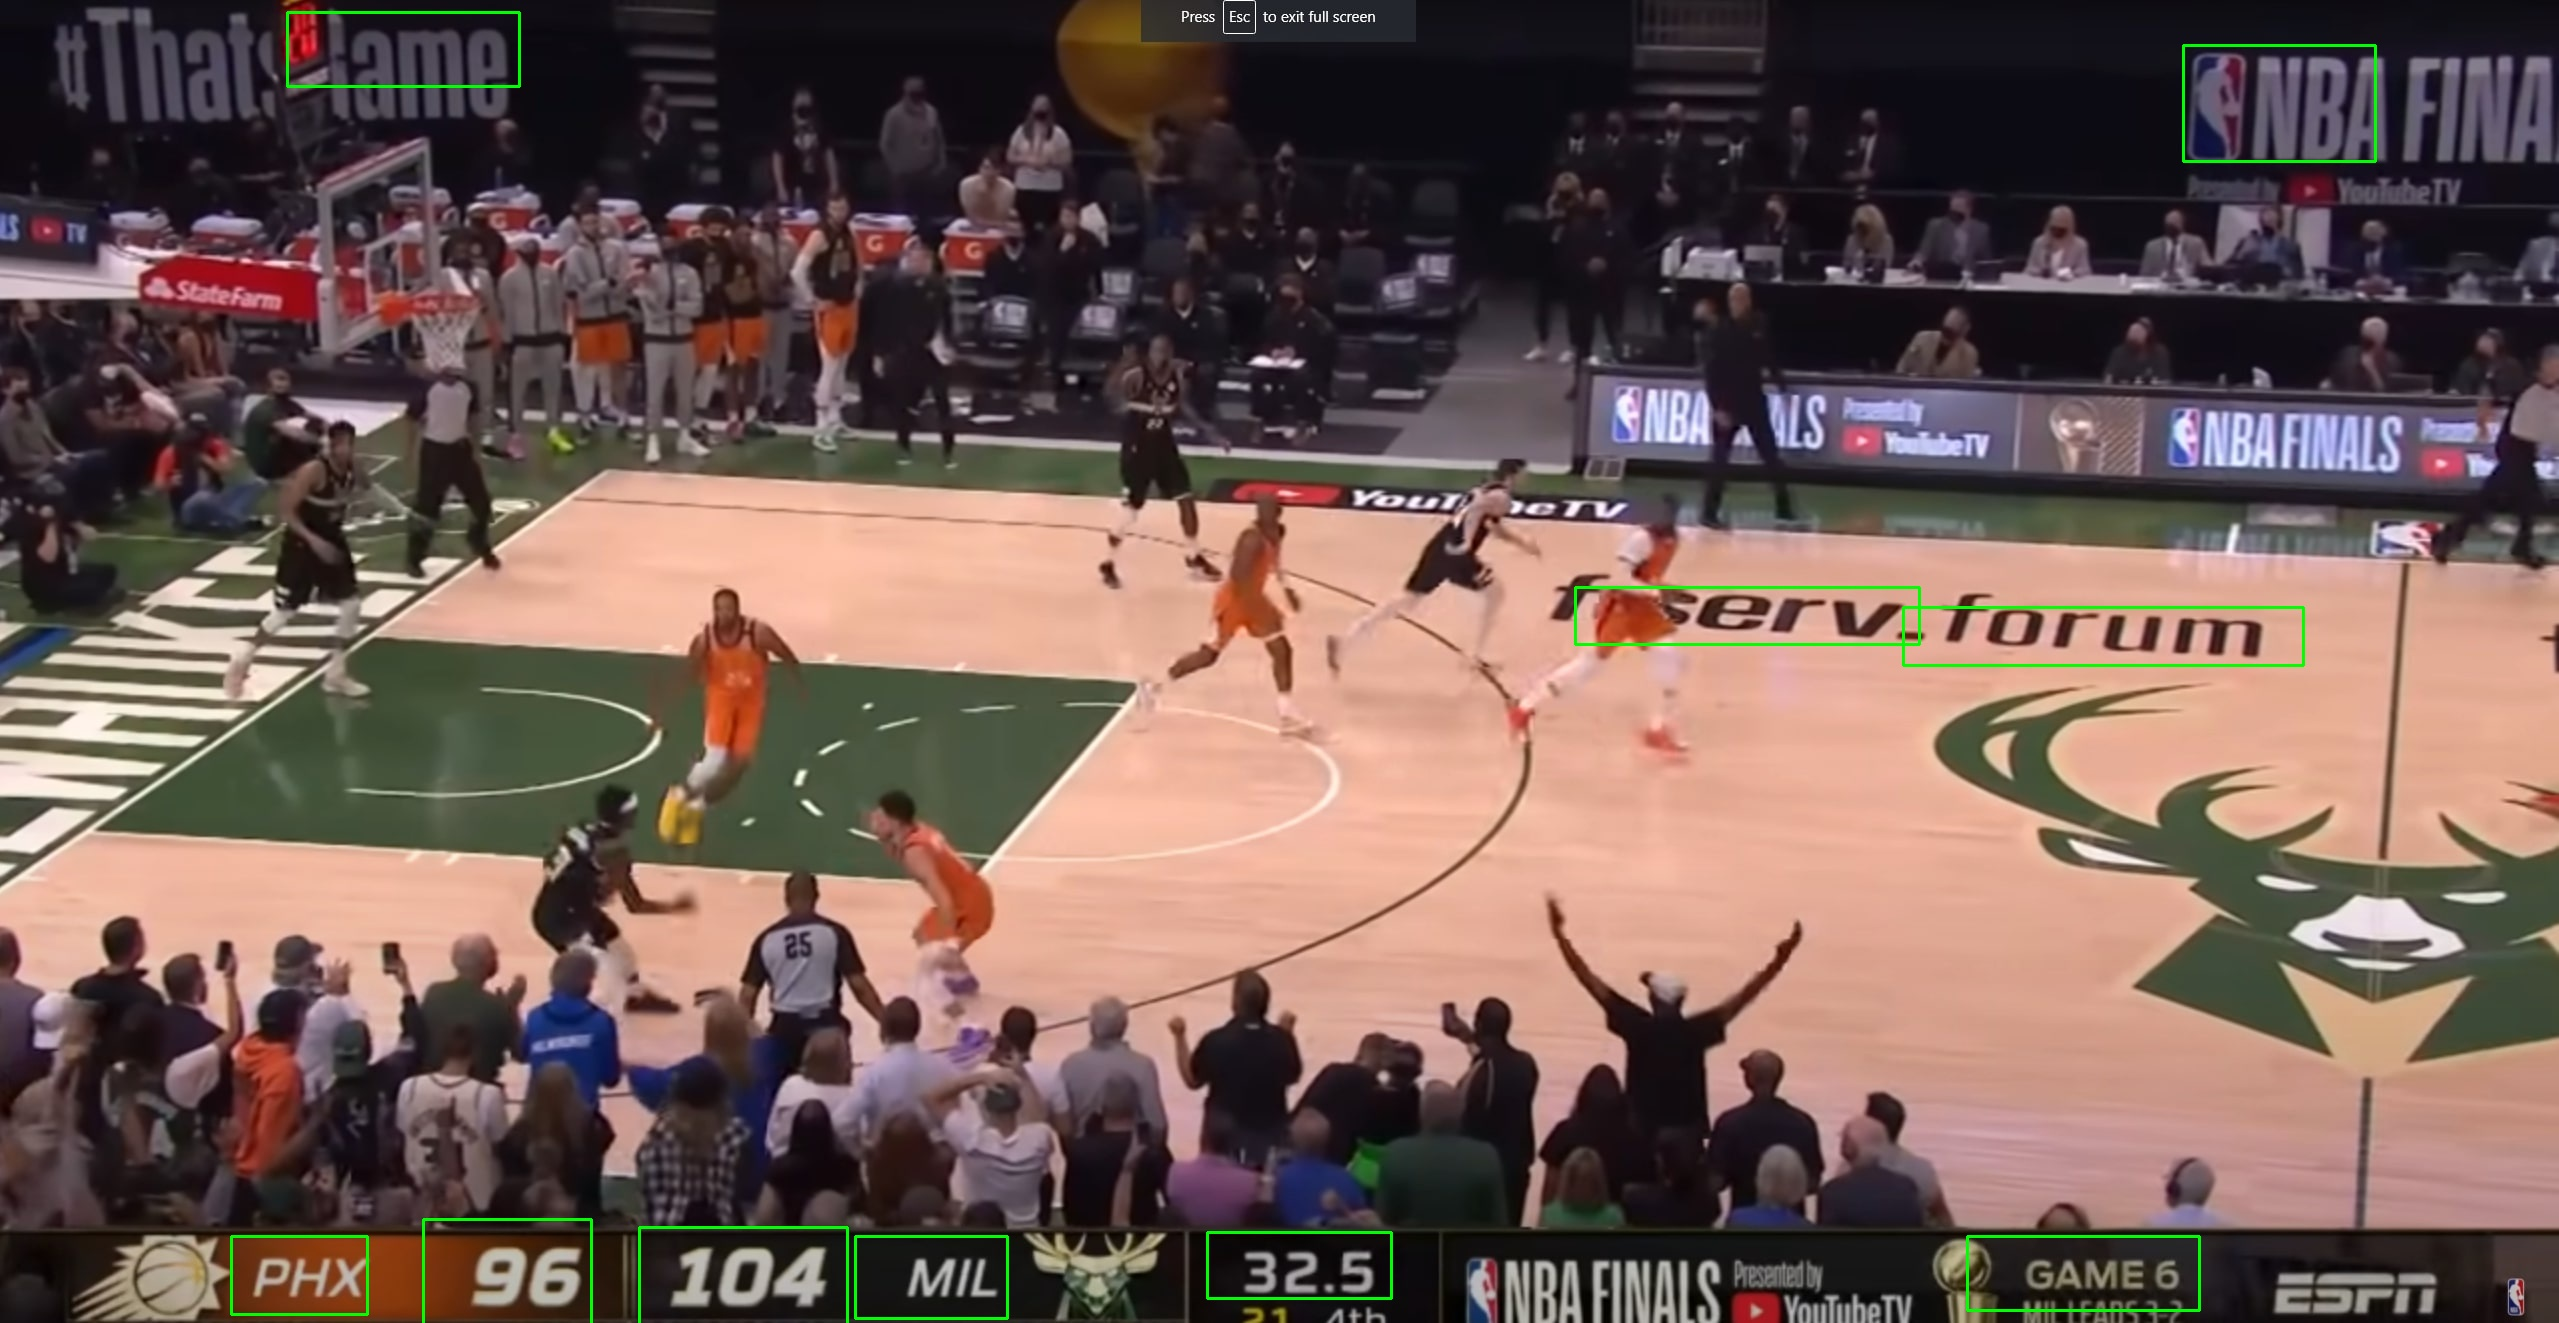

In [3]:
# Display image with bounded rectangles where text is present
# Glad to see EAST preforming extremely well with the NBA overlays bar (bar on bottom displaying score, time, etc.)
from IPython.display import Image
Image(filename='data/text_rectangles_in_image.jpg')

In [4]:
# Finding the best guessed boxes for team abbreviation
bestRec1, bestRec2 = find_best_rectangles(rectangles)

In [5]:
# cropping the image and sending it for preprocessing for pytesseract to extract team abbv
# Home team seems to always be the abbv to the right i.e. crop_image_2
crop_image_1 = image[bestRec1['startY']:bestRec1['endY'], bestRec1['startX']:bestRec1['endX']]
crop_image_2 = image[bestRec2['startY']:bestRec2['endY'], bestRec2['startX']:bestRec2['endX']]

AWAY = get_abbv(crop_image_1)
HOME = get_abbv(crop_image_2)

In [6]:
print('AWAY', AWAY)
print('HOME', HOME)

AWAY PHX
HOME MIL


# HOME RECORD PREDICTION

# A Look Into Feature Importance/EDA

The results from the feature importance makes sense and followed my initial intuition which was in order to conclude if the home team wins, field goal percentage and overall points would be the most influential factors.

The results from the EDA graphs might not seem to interesting but they provide some compelling insights. 

Clearly, there is no distinct correlation between FG_PCT_home and HOME_TEAM_WINS. This is expected because although a team might shoot particularly well, this doesn't mean they will always win the game. They will need to supplement the good FG percentage with a fair number of shots while also playing good defensively to have the best chance at winning a game. 

Additionally, looking into FG percentage vs PTS_home, when a team has a low FG percentage, usually they have a low score. On the other hand, when a team has a high FG percentage, they have a higher score but not the highest. The highest scoring games come from a mid-FG percentage game which makes sense, the more shots a team puts up, the more likely they are to score, however, they will also most likely miss more shots which damages their FG percentage. 

Unfortunately, this data doesn't have a field to indicate how long a team has possession of the ball which I assume would also be one of the most influential factors to determining a win (alongside what we have already).

As a result, the data doesn't seem to be linearly correlated which means that hidden layers would be implemented into the neural net. 

In [7]:
# data from 2004 to 2020
games = pd.read_csv('data/games.csv')
teams = pd.read_csv('data/teams.csv')

In [8]:
games.head(5)

,GAME_DATE_EST,GAME_ID,GAME_STATUS_TEXT,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,...,AST_home,REB_home,TEAM_ID_away,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS
0,2021-05-26,42000102,Final,1610612755,1610612764,2020,1610612755,120.0,0.557,0.684,...,26.0,45.0,1610612764,95.0,0.402,0.633,0.091,22.0,40.0,1
1,2021-05-26,42000132,Final,1610612752,1610612737,2020,1610612752,101.0,0.383,0.739,...,15.0,54.0,1610612737,92.0,0.369,0.818,0.273,17.0,41.0,1
2,2021-05-26,42000142,Final,1610612762,1610612763,2020,1610612762,141.0,0.544,0.774,...,28.0,42.0,1610612763,129.0,0.541,0.763,0.348,20.0,33.0,1
3,2021-05-25,42000112,Final,1610612751,1610612738,2020,1610612751,130.0,0.523,0.955,...,31.0,46.0,1610612738,108.0,0.424,0.783,0.353,23.0,43.0,1
4,2021-05-25,42000152,Final,1610612756,1610612747,2020,1610612756,102.0,0.465,0.933,...,21.0,31.0,1610612747,109.0,0.450,0.871,0.303,24.0,39.0,0


In [9]:
teams.head(5)

,LEAGUE_ID,TEAM_ID,MIN_YEAR,MAX_YEAR,ABBREVIATION,NICKNAME,YEARFOUNDED,CITY,ARENA,ARENACAPACITY,OWNER,GENERALMANAGER,HEADCOACH,DLEAGUEAFFILIATION
0,0,1610612737,1949,2019,ATL,Hawks,1949,Atlanta,State Farm Arena,18729.0,Tony Ressler,Travis Schlenk,Lloyd Pierce,Erie Bayhawks
1,0,1610612738,1946,2019,BOS,Celtics,1946,Boston,TD Garden,18624.0,Wyc Grousbeck,Danny Ainge,Brad Stevens,Maine Red Claws
2,0,1610612740,2002,2019,NOP,Pelicans,2002,New Orleans,Smoothie King Center,NaN,Tom Benson,Trajan Langdon,Alvin Gentry,No Affiliate
3,0,1610612741,1966,2019,CHI,Bulls,1966,Chicago,United Center,21711.0,Jerry Reinsdorf,Gar Forman,Jim Boylen,Windy City Bulls
4,0,1610612742,1980,2019,DAL,Mavericks,1980,Dallas,American Airlines Center,19200.0,Mark Cuban,Donnie Nelson,Rick Carlisle,Texas Legends


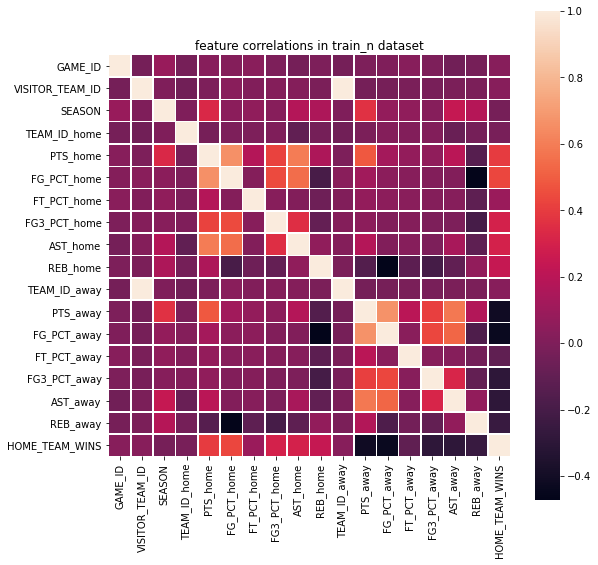

In [10]:
# Generate feature correlations
sml = Speedml('data/games.csv',  
              'data/games.csv',
              target = 'HOME_TEAM_WINS',
              uid = 'HOME_TEAM_ID')
sml.train.head()
sml.plot.correlate()

Text(0.5, 1.0, 'FG_PCT vs WIN')

Text(0.5, 0, 'FG_PCT_home')

Text(0, 0.5, 'HOME_TEAM_WINS')

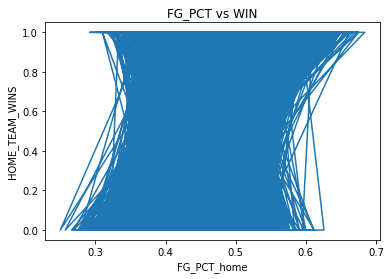

In [11]:
# FG PCT VS WINS
x_axis = games['FG_PCT_home']
y_axis = games['HOME_TEAM_WINS']
plt.title('FG_PCT vs WIN')
plt.xlabel('FG_PCT_home')
plt.ylabel('HOME_TEAM_WINS')
plt.plot(x_axis, y_axis)
plt.show()

Text(0.5, 1.0, 'FG_PCT vs PTS')

Text(0.5, 0, 'FG_PCT_home')

Text(0, 0.5, 'PTS_home')

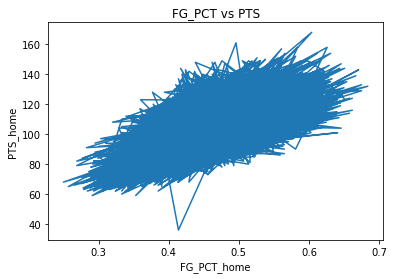

In [12]:
# FG PCT VS PTS
x_axis = games['FG_PCT_home']
y_axis = games['PTS_home']
plt.title('FG_PCT vs PTS')
plt.xlabel('FG_PCT_home')
plt.ylabel('PTS_home')
plt.plot(x_axis, y_axis)
plt.show()

# Data Preprocessing

In [13]:
# filtering data for the past 5 seasons since games before that are probably not relevant to team's success
games = games.loc[games['SEASON'].isin(['2016', '2017', '2018', '2019', '2020'])]

In [14]:
# Creating a dictionary to map team ids to abbreviations
teamsDict = {}
for index, row in teams.iterrows():
    teamsDict[row['TEAM_ID']] = row['ABBREVIATION']

In [15]:
# Adding HOME and AWAY team abbreviation columns
teamHome = []
teamAway = []
for index, row in games.iterrows():
    teamHome.append(teamsDict[row['HOME_TEAM_ID']])
    teamAway.append(teamsDict[row['VISITOR_TEAM_ID']])
games['HOME_TEAM'] = teamHome
games['AWAY_TEAM'] = teamAway

In [16]:
homeDF = games[games['HOME_TEAM'] == HOME]

In [17]:
homeDF.head(5)

,GAME_DATE_EST,GAME_ID,GAME_STATUS_TEXT,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,...,TEAM_ID_away,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS,HOME_TEAM,AWAY_TEAM
6,2021-05-24,42000122,Final,1610612749,1610612748,2020,1610612749,132.0,0.489,0.900,...,1610612748,98.0,0.402,0.686,0.286,20.0,36.0,1,MIL,MIA
12,2021-05-22,42000121,Final,1610612749,1610612748,2020,1610612749,109.0,0.438,0.606,...,1610612748,107.0,0.364,0.789,0.400,22.0,51.0,1,MIL,MIA
42,2021-05-15,22001062,Final,1610612749,1610612748,2020,1610612749,122.0,0.535,0.708,...,1610612748,108.0,0.417,0.750,0.449,25.0,38.0,1,MIL,MIA
73,2021-05-11,22001038,Final,1610612749,1610612753,2020,1610612749,114.0,0.426,0.741,...,1610612753,102.0,0.415,0.700,0.333,18.0,52.0,1,MIL,ORL
102,2021-05-07,22001006,Final,1610612749,1610612745,2020,1610612749,141.0,0.537,0.870,...,1610612745,133.0,0.500,0.667,0.472,36.0,37.0,1,MIL,HOU


# Encoding

In [18]:
# Creating a dataframe consiting of only the important features
# Season will be important for splitting up training + test sets
df = homeDF.filter(items=['HOME_TEAM', 'AWAY_TEAM', 'SEASON', 'PTS_home', 'FG_PCT_home', 'HOME_TEAM_WINS'])
df['HOME_TEAM'] = df['HOME_TEAM']
df['AWAY_TEAM'] = df['AWAY_TEAM']

In [19]:
df.head(5)

,HOME_TEAM,AWAY_TEAM,SEASON,PTS_home,FG_PCT_home,HOME_TEAM_WINS
6,MIL,MIA,2020,132.0,0.489,1
12,MIL,MIA,2020,109.0,0.438,1
42,MIL,MIA,2020,122.0,0.535,1
73,MIL,ORL,2020,114.0,0.426,1
102,MIL,HOU,2020,141.0,0.537,1


In [20]:
# One hot encoding columns + restructuring
# df = one_hot(df, 'HOME_TEAM')
df = one_hot(df, 'AWAY_TEAM')
df = clean_df(df)

In [21]:
df.head(5)

,HOME_TEAM,SEASON,ATL,BKN,BOS,CHA,CHI,CLE,DAL,DEN,...,PHX,POR,SAC,SAS,TOR,UTA,WAS,PTS_HOME,FG_PCT_HOME,HOME_TEAM_WON
6,MIL,2020,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,132.0,0.489,1
12,MIL,2020,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,109.0,0.438,1
42,MIL,2020,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,122.0,0.535,1
73,MIL,2020,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,114.0,0.426,1
102,MIL,2020,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,141.0,0.537,1


In [22]:
# Scaling PTS since imbalances between PTS and other variables
scaler = MinMaxScaler()
df['PTS_HOME'] = scaler.fit_transform(df['PTS_HOME'].values.reshape(-1,1))
trainDF = df[df['SEASON'] < 2020]
testDF = df[df['SEASON'] == 2020]
print(trainDF.shape)
print(testDF.shape)

(189, 34)
(42, 34)


In [23]:
df.head(5)

,HOME_TEAM,SEASON,ATL,BKN,BOS,CHA,CHI,CLE,DAL,DEN,...,PHX,POR,SAC,SAS,TOR,UTA,WAS,PTS_HOME,FG_PCT_HOME,HOME_TEAM_WON
6,MIL,2020,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.746667,0.489,1
12,MIL,2020,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.440000,0.438,1
42,MIL,2020,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.613333,0.535,1
73,MIL,2020,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.506667,0.426,1
102,MIL,2020,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.866667,0.537,1


# Training

In [24]:
# Create training and test sets
X_train = trainDF.iloc[:, 2:-1].values
y_train = trainDF.iloc[:, -1].values
X_test = testDF.iloc[:, 2:-1].values
y_test = testDF.iloc[:, -1].values

In [25]:
# Model Architecture
nn = create_model()

In [26]:
learn = nn.fit(X_train, y_train, verbose=1, epochs=1000, validation_data=(X_test, y_test))

Epoch 1/1000
6/6 [==============================] - 0s 21ms/step - loss: 0.6712 - accuracy: 0.6349 - val_loss: 0.6552 - val_accuracy: 0.5714
Epoch 2/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.6583 - accuracy: 0.6402 - val_loss: 0.6422 - val_accuracy: 0.6667
Epoch 3/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.6457 - accuracy: 0.6878 - val_loss: 0.6311 - val_accuracy: 0.7143
Epoch 4/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.6344 - accuracy: 0.6878 - val_loss: 0.6215 - val_accuracy: 0.7143
Epoch 5/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.6262 - accuracy: 0.6931 - val_loss: 0.6130 - val_accuracy: 0.7143
Epoch 6/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.6169 - accuracy: 0.6931 - val_loss: 0.6063 - val_accuracy: 0.7143
Epoch 7/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.6094 - accuracy: 0.6931 - val_loss: 0.6003 - val_accuracy: 0.7143
Epoch 8/1000
6/6 [=

6/6 [==============================] - 0s 3ms/step - loss: 0.4286 - accuracy: 0.7884 - val_loss: 0.6070 - val_accuracy: 0.6667
Epoch 118/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.4282 - accuracy: 0.7884 - val_loss: 0.6071 - val_accuracy: 0.6667
Epoch 119/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.4272 - accuracy: 0.7884 - val_loss: 0.6084 - val_accuracy: 0.6667
Epoch 120/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.4265 - accuracy: 0.7884 - val_loss: 0.6086 - val_accuracy: 0.6667
Epoch 121/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.4260 - accuracy: 0.7884 - val_loss: 0.6088 - val_accuracy: 0.6667
Epoch 122/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.4252 - accuracy: 0.7884 - val_loss: 0.6094 - val_accuracy: 0.6667
Epoch 123/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.4245 - accuracy: 0.7884 - val_loss: 0.6098 - val_accuracy: 0.6667
Epoch 124/1000
6/6 [=

Epoch 175/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3976 - accuracy: 0.8148 - val_loss: 0.6297 - val_accuracy: 0.6667
Epoch 176/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3971 - accuracy: 0.8148 - val_loss: 0.6303 - val_accuracy: 0.6667
Epoch 177/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3969 - accuracy: 0.8148 - val_loss: 0.6313 - val_accuracy: 0.6667
Epoch 178/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3964 - accuracy: 0.8095 - val_loss: 0.6317 - val_accuracy: 0.6667
Epoch 179/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3959 - accuracy: 0.8148 - val_loss: 0.6319 - val_accuracy: 0.6667
Epoch 180/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3956 - accuracy: 0.8148 - val_loss: 0.6323 - val_accuracy: 0.6667
Epoch 181/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3950 - accuracy: 0.8095 - val_loss: 0.6327 - val_accuracy: 0.6667
Epoch 

Epoch 233/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3800 - accuracy: 0.8201 - val_loss: 0.6510 - val_accuracy: 0.6429
Epoch 234/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3797 - accuracy: 0.8201 - val_loss: 0.6511 - val_accuracy: 0.6429
Epoch 235/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3795 - accuracy: 0.8201 - val_loss: 0.6511 - val_accuracy: 0.6429
Epoch 236/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3793 - accuracy: 0.8201 - val_loss: 0.6517 - val_accuracy: 0.6429
Epoch 237/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3791 - accuracy: 0.8201 - val_loss: 0.6518 - val_accuracy: 0.6429
Epoch 238/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3788 - accuracy: 0.8201 - val_loss: 0.6529 - val_accuracy: 0.6429
Epoch 239/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3787 - accuracy: 0.8201 - val_loss: 0.6537 - val_accuracy: 0.6429
Epoch 

Epoch 291/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3701 - accuracy: 0.8201 - val_loss: 0.6776 - val_accuracy: 0.6429
Epoch 292/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3703 - accuracy: 0.8148 - val_loss: 0.6779 - val_accuracy: 0.6429
Epoch 293/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3699 - accuracy: 0.8148 - val_loss: 0.6784 - val_accuracy: 0.6429
Epoch 294/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3698 - accuracy: 0.8201 - val_loss: 0.6784 - val_accuracy: 0.6429
Epoch 295/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3695 - accuracy: 0.8201 - val_loss: 0.6786 - val_accuracy: 0.6429
Epoch 296/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3699 - accuracy: 0.8201 - val_loss: 0.6786 - val_accuracy: 0.6429
Epoch 297/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3696 - accuracy: 0.8148 - val_loss: 0.6797 - val_accuracy: 0.6429
Epoch 

Epoch 349/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3634 - accuracy: 0.8148 - val_loss: 0.7050 - val_accuracy: 0.6429
Epoch 350/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3631 - accuracy: 0.8148 - val_loss: 0.7055 - val_accuracy: 0.6429
Epoch 351/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3632 - accuracy: 0.8148 - val_loss: 0.7053 - val_accuracy: 0.6429
Epoch 352/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3631 - accuracy: 0.8148 - val_loss: 0.7061 - val_accuracy: 0.6429
Epoch 353/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3631 - accuracy: 0.8148 - val_loss: 0.7069 - val_accuracy: 0.6429
Epoch 354/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3631 - accuracy: 0.8148 - val_loss: 0.7066 - val_accuracy: 0.6429
Epoch 355/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3628 - accuracy: 0.8148 - val_loss: 0.7070 - val_accuracy: 0.6429
Epoch 

Epoch 407/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3587 - accuracy: 0.8254 - val_loss: 0.7280 - val_accuracy: 0.6429
Epoch 408/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3588 - accuracy: 0.8254 - val_loss: 0.7291 - val_accuracy: 0.6429
Epoch 409/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3588 - accuracy: 0.8254 - val_loss: 0.7294 - val_accuracy: 0.6429
Epoch 410/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3586 - accuracy: 0.8254 - val_loss: 0.7299 - val_accuracy: 0.6429
Epoch 411/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3584 - accuracy: 0.8254 - val_loss: 0.7297 - val_accuracy: 0.6429
Epoch 412/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3584 - accuracy: 0.8254 - val_loss: 0.7304 - val_accuracy: 0.6429
Epoch 413/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3585 - accuracy: 0.8254 - val_loss: 0.7307 - val_accuracy: 0.6429
Epoch 

Epoch 465/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3550 - accuracy: 0.8254 - val_loss: 0.7474 - val_accuracy: 0.6429
Epoch 466/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3545 - accuracy: 0.8254 - val_loss: 0.7476 - val_accuracy: 0.6429
Epoch 467/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3545 - accuracy: 0.8254 - val_loss: 0.7484 - val_accuracy: 0.6429
Epoch 468/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3549 - accuracy: 0.8254 - val_loss: 0.7491 - val_accuracy: 0.6429
Epoch 469/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3544 - accuracy: 0.8254 - val_loss: 0.7487 - val_accuracy: 0.6429
Epoch 470/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3544 - accuracy: 0.8254 - val_loss: 0.7491 - val_accuracy: 0.6429
Epoch 471/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3542 - accuracy: 0.8254 - val_loss: 0.7491 - val_accuracy: 0.6429
Epoch 

Epoch 523/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3512 - accuracy: 0.8307 - val_loss: 0.7666 - val_accuracy: 0.6429
Epoch 524/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3510 - accuracy: 0.8307 - val_loss: 0.7672 - val_accuracy: 0.6429
Epoch 525/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3509 - accuracy: 0.8307 - val_loss: 0.7679 - val_accuracy: 0.6429
Epoch 526/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3514 - accuracy: 0.8307 - val_loss: 0.7680 - val_accuracy: 0.6429
Epoch 527/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3510 - accuracy: 0.8307 - val_loss: 0.7666 - val_accuracy: 0.6429
Epoch 528/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3509 - accuracy: 0.8307 - val_loss: 0.7669 - val_accuracy: 0.6429
Epoch 529/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3509 - accuracy: 0.8307 - val_loss: 0.7683 - val_accuracy: 0.6429
Epoch 

Epoch 581/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3477 - accuracy: 0.8307 - val_loss: 0.7843 - val_accuracy: 0.6429
Epoch 582/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3480 - accuracy: 0.8307 - val_loss: 0.7843 - val_accuracy: 0.6429
Epoch 583/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3478 - accuracy: 0.8360 - val_loss: 0.7844 - val_accuracy: 0.6429
Epoch 584/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3479 - accuracy: 0.8360 - val_loss: 0.7861 - val_accuracy: 0.6429
Epoch 585/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3478 - accuracy: 0.8307 - val_loss: 0.7859 - val_accuracy: 0.6429
Epoch 586/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3478 - accuracy: 0.8307 - val_loss: 0.7862 - val_accuracy: 0.6429
Epoch 587/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3476 - accuracy: 0.8307 - val_loss: 0.7863 - val_accuracy: 0.6429
Epoch 

Epoch 639/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3450 - accuracy: 0.8307 - val_loss: 0.8005 - val_accuracy: 0.6429
Epoch 640/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3448 - accuracy: 0.8307 - val_loss: 0.8005 - val_accuracy: 0.6429
Epoch 641/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3447 - accuracy: 0.8307 - val_loss: 0.8005 - val_accuracy: 0.6429
Epoch 642/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3448 - accuracy: 0.8307 - val_loss: 0.8008 - val_accuracy: 0.6429
Epoch 643/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3449 - accuracy: 0.8307 - val_loss: 0.8004 - val_accuracy: 0.6429
Epoch 644/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3448 - accuracy: 0.8360 - val_loss: 0.8001 - val_accuracy: 0.6429
Epoch 645/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3447 - accuracy: 0.8360 - val_loss: 0.8009 - val_accuracy: 0.6429
Epoch 

Epoch 697/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3422 - accuracy: 0.8360 - val_loss: 0.8137 - val_accuracy: 0.6429
Epoch 698/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3426 - accuracy: 0.8360 - val_loss: 0.8144 - val_accuracy: 0.6429
Epoch 699/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3428 - accuracy: 0.8413 - val_loss: 0.8146 - val_accuracy: 0.6429
Epoch 700/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3418 - accuracy: 0.8360 - val_loss: 0.8142 - val_accuracy: 0.6429
Epoch 701/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3420 - accuracy: 0.8413 - val_loss: 0.8147 - val_accuracy: 0.6429
Epoch 702/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3420 - accuracy: 0.8413 - val_loss: 0.8149 - val_accuracy: 0.6429
Epoch 703/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3422 - accuracy: 0.8360 - val_loss: 0.8154 - val_accuracy: 0.6429
Epoch 

Epoch 755/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3395 - accuracy: 0.8413 - val_loss: 0.8285 - val_accuracy: 0.6429
Epoch 756/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3394 - accuracy: 0.8413 - val_loss: 0.8284 - val_accuracy: 0.6429
Epoch 757/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3395 - accuracy: 0.8413 - val_loss: 0.8286 - val_accuracy: 0.6429
Epoch 758/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3393 - accuracy: 0.8413 - val_loss: 0.8277 - val_accuracy: 0.6429
Epoch 759/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3392 - accuracy: 0.8413 - val_loss: 0.8282 - val_accuracy: 0.6429
Epoch 760/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3392 - accuracy: 0.8413 - val_loss: 0.8289 - val_accuracy: 0.6429
Epoch 761/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3392 - accuracy: 0.8413 - val_loss: 0.8296 - val_accuracy: 0.6429
Epoch 

Epoch 813/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3371 - accuracy: 0.8413 - val_loss: 0.8407 - val_accuracy: 0.6429
Epoch 814/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3369 - accuracy: 0.8413 - val_loss: 0.8407 - val_accuracy: 0.6429
Epoch 815/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3371 - accuracy: 0.8360 - val_loss: 0.8418 - val_accuracy: 0.6429
Epoch 816/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3375 - accuracy: 0.8413 - val_loss: 0.8417 - val_accuracy: 0.6429
Epoch 817/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3367 - accuracy: 0.8413 - val_loss: 0.8422 - val_accuracy: 0.6429
Epoch 818/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3369 - accuracy: 0.8413 - val_loss: 0.8423 - val_accuracy: 0.6429
Epoch 819/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3366 - accuracy: 0.8413 - val_loss: 0.8429 - val_accuracy: 0.6429
Epoch 

Epoch 871/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3346 - accuracy: 0.8413 - val_loss: 0.8530 - val_accuracy: 0.6429
Epoch 872/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3347 - accuracy: 0.8413 - val_loss: 0.8533 - val_accuracy: 0.6429
Epoch 873/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3345 - accuracy: 0.8413 - val_loss: 0.8536 - val_accuracy: 0.6429
Epoch 874/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3343 - accuracy: 0.8413 - val_loss: 0.8548 - val_accuracy: 0.6429
Epoch 875/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3344 - accuracy: 0.8413 - val_loss: 0.8550 - val_accuracy: 0.6429
Epoch 876/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3347 - accuracy: 0.8413 - val_loss: 0.8553 - val_accuracy: 0.6429
Epoch 877/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3342 - accuracy: 0.8413 - val_loss: 0.8555 - val_accuracy: 0.6429
Epoch 

Epoch 929/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3325 - accuracy: 0.8413 - val_loss: 0.8675 - val_accuracy: 0.6429
Epoch 930/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3323 - accuracy: 0.8413 - val_loss: 0.8679 - val_accuracy: 0.6429
Epoch 931/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3323 - accuracy: 0.8413 - val_loss: 0.8675 - val_accuracy: 0.6429
Epoch 932/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3322 - accuracy: 0.8413 - val_loss: 0.8668 - val_accuracy: 0.6429
Epoch 933/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3327 - accuracy: 0.8413 - val_loss: 0.8671 - val_accuracy: 0.6429
Epoch 934/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3320 - accuracy: 0.8413 - val_loss: 0.8681 - val_accuracy: 0.6429
Epoch 935/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3321 - accuracy: 0.8413 - val_loss: 0.8690 - val_accuracy: 0.6429
Epoch 

Epoch 987/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3300 - accuracy: 0.8413 - val_loss: 0.8805 - val_accuracy: 0.6429
Epoch 988/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3302 - accuracy: 0.8413 - val_loss: 0.8804 - val_accuracy: 0.6429
Epoch 989/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3299 - accuracy: 0.8413 - val_loss: 0.8807 - val_accuracy: 0.6429
Epoch 990/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3298 - accuracy: 0.8413 - val_loss: 0.8802 - val_accuracy: 0.6429
Epoch 991/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3296 - accuracy: 0.8413 - val_loss: 0.8814 - val_accuracy: 0.6429
Epoch 992/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3298 - accuracy: 0.8466 - val_loss: 0.8810 - val_accuracy: 0.6429
Epoch 993/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3296 - accuracy: 0.8466 - val_loss: 0.8801 - val_accuracy: 0.6429
Epoch 

In [27]:
loss = learn.history['loss']
val_loss = learn.history['val_loss']
acc = learn.history['accuracy']

Text(0.5, 1.0, 'Accuracy')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Accuracy')

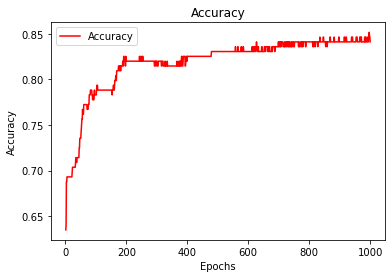

In [28]:
# Accuracy plot
epochs = range(1, len(loss)+ 1)
plt.plot(epochs, acc, 'r', label='Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Text(0.5, 1.0, 'Training loss')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Loss')

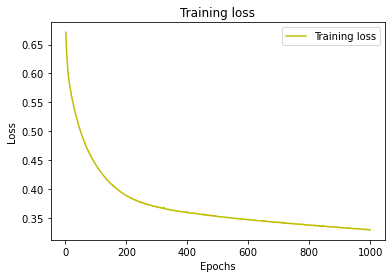

In [29]:
# Training Loss Plot
epochs = range(1, len(loss)+ 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Text(0.5, 1.0, 'Validation loss')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Loss')

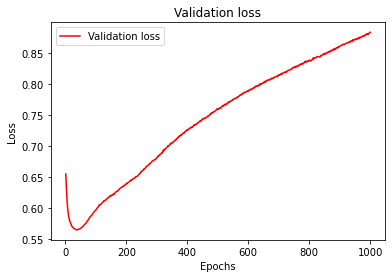

In [30]:
# Validation Loss plot
epochs = range(1, len(loss)+ 1)
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [31]:
# Get predictions and accuracy
testDF = get_predictions(testDF, X_test)
accuracy = get_accuracy(testDF)

<ipython-input-1-08311a43bfcf>:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testDF['prediction'] = prediction_test
<ipython-input-1-08311a43bfcf>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testDF['binary_prediction'] = np.where(testDF['prediction']<0.5, 0, 1)


In [32]:
# Display Home Team record
pred_wins = testDF['binary_prediction'].value_counts()[1]
print(HOME,'2020 PREDICTED HOME RECORD', pred_wins, '-', 42-pred_wins)
print(HOME,'2020 ACTUAL HOME RECORD', '30 - 5')

MIL PREDICTED 2020 HOME RECORD 35 - 7
MIL ACTUAL 2020 HOME RECORD 30 - 5


# Drawbacks/Insights

This project definitely has some drawbacks and due to the time constraint, I decided not to explore those avenues. Here were some of the clear drawbacks:

### Computer Vision
* There is an issue with the inconsistency of NBA abbreviations and what is actually displayed on the overlay in some cases. I noticed this when I was testing an image of the San Antonio Spurs vs Golden State Warriors. San Antonio Spurs's abbreviation is SAS, however, in the overlay it was presented as SA. To solve this, there should be a matching implementation that will match the similiarity of characters of what pytesseract extracts and a NBA team abbreviation dictionary.

    
* There could also be the issue of if 'SA' maps to SAS (Spurs) or SAC (Kings). In which it would be ideal to extract the background image color behind the letters and match that to the team's colors.

    
* I looked at a few images from the past years and the overlays seem to be inconsistent throughout the years, so the optimal reference variables of REF_START_X_1, REF_END_X_1, .. would have to be changed if the overlay is different for the current year.


### NN Model
* The model intakes a small amount of features besides the one hot encoding, FT_PCT_HOME and PTS_HOME which are two variables I found to be good indicators of the home team winning and features that can generally be easier to predict rather than, assists, rebounds, turnovers, etc which tend to be very game-specific. I wish there was more data and specifically the addition of the overall time the team had possession of the ball. I think there would be some eye-opening EDA on possession time with respect to the features we already have in our dataset.
    
    
* I believe there is a specific window of games that are relevant to the team's success. For instance, MIL's games in the early 2000s shouldn't affect the probably it has to win in this current year (hence, why I only used data from the last 5 seasons which is still pushing the older-game-limit threshold). Additionally, in the NBA, players seem to switch teams/get injured fairly often which can have huge impacts on the team's success/failures. This model doesn't take that into consideration. For example, GSW might have a great upcoming year since Klay Thompson is back, who has an immediate impact towards GSW's success, contrasting its previous regular season record of being 39-33 (0.542). Additionally, the more data we would be able to get, that is relevant, the better. Some ideas to add more data to our current dataset could be to either synthesize data though simulated games from predictions and adding that in or to use SMOTE.
    
    
* Lastly, I wanted to note the weird graph comparision between Accuracy vs Validation Loss. This could probably be explored a lot more in-depth. What I expected was that if the validation loss is moving up as epochs move up, then accuracy will slowly diminish, however, in this case accuracy was moving up as well. Why? My guess is that the border-line predictions actually moved in favor of what the real value were (e.g. If Golden State wins the game against San Antonio, the prediction moves from 0.45 to 0.55 where the prediction moves from being incorrect to being correct and the **accuracy** is affected). As a result, the accuracy will increase. Now looking at validation loss, this has to do more with the confidence of the prediction. So, my theory is that when this particular model is wrong, it is wrong by a lot (e.g. If Golden State wins the game against San Antonio, the prediction moves from 0.45 to 0.25 where the confidence of the prediction moves from being incorrect to being even more incorrect and the **validation loss** is affected). As a result, the validation loss will increase.